<a href="https://colab.research.google.com/github/fjadidi2001/Denoise/blob/main/Enhanced_Lightweight_Image_Denoising_Networks_with_Adaptive_Feature_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import numpy as np
import torch

# Set base directory
base_dir = '/content/drive/MyDrive/SSNet'
os.makedirs(f'{base_dir}/data', exist_ok=True)
os.makedirs(f'{base_dir}/output', exist_ok=True)
os.makedirs(f'{base_dir}/saved_models', exist_ok=True)

# Set random seeds for reproducibility
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

print("Project Setup Complete!")
print(f"Base directory: {base_dir}")
print(f"CUDA available: {torch.cuda.is_available()}")

Project Setup Complete!
Base directory: /content/drive/MyDrive/SSNet
CUDA available: True


Dataset loaded successfully
Processing BSR dataset...
Found 200 training, 100 validation, 200 test images
Processing training image 1/200
Processing training image 51/200
Processing training image 101/200
Processing training image 151/200

Dataset Statistics:
       Subset  Images  Patches  HDF5 Size (MB)
0       Train     200     2400     1800.876221
1  Validation     100      100      176.735031
2        Test     200      200      353.470795


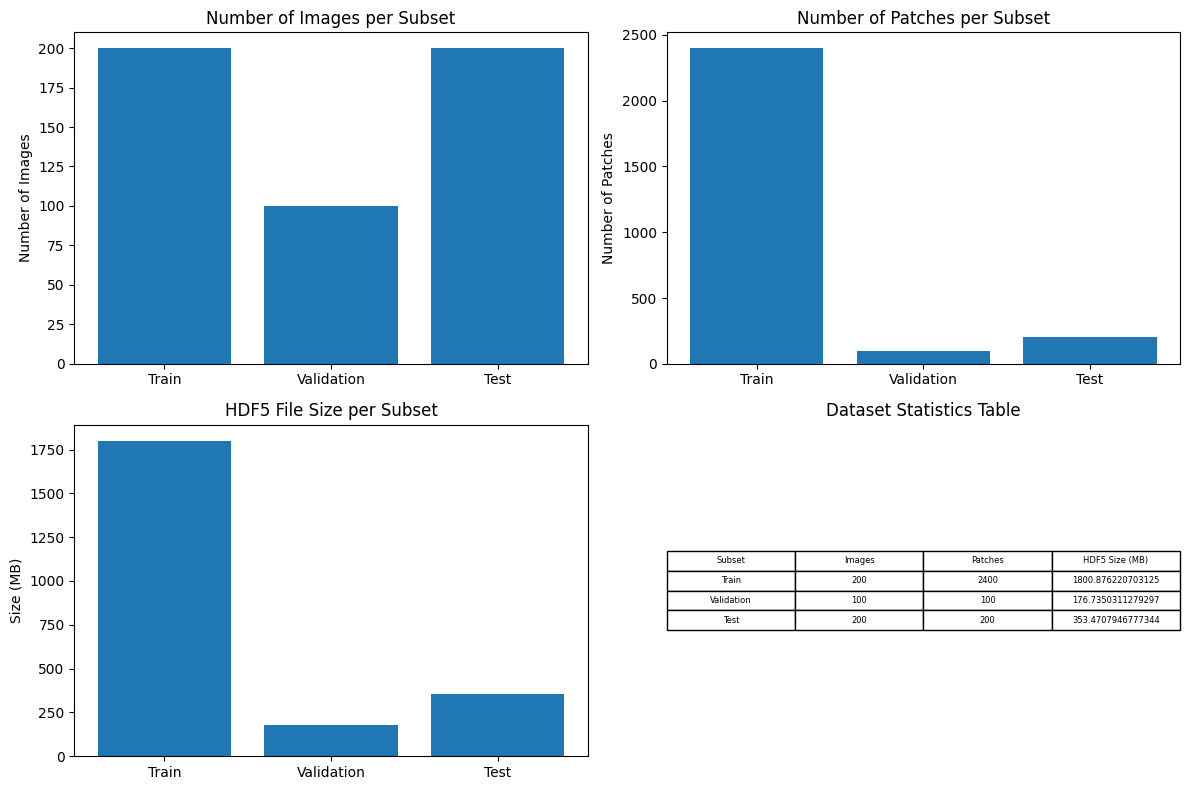

In [3]:
import cv2
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def normalize(data):
    """Normalize data to [0, 1] range"""
    return data / 255.0

def Im2Patch(img, win, stride=1):
    """Extract patches from image"""
    k = 0
    endc = img.shape[0]
    endw = img.shape[1]
    endh = img.shape[2]
    patch = img[:, 0:endw-win+0+1:stride, 0:endh-win+0+1:stride]
    TotalPatNum = patch.shape[1] * patch.shape[2]
    Y = np.zeros([endc, win*win, TotalPatNum], np.float32)
    for i in range(win):
        for j in range(win):
            patch = img[:, i:endw-win+i+1:stride, j:endh-win+j+1:stride]
            Y[:, k, :] = np.array(patch[:]).reshape(endc, TotalPatNum)
            k = k + 1
    return Y.reshape([endc, win, win, TotalPatNum])

def data_augmentation(image, mode):
    """Apply data augmentation"""
    out = np.transpose(image, (1, 2, 0))
    if mode == 0:
        out = out
    elif mode == 1:
        out = np.flipud(out)
    elif mode == 2:
        out = np.rot90(out)
    elif mode == 3:
        out = np.rot90(out)
        out = np.flipud(out)
    elif mode == 4:
        out = np.rot90(out, k=2)
    elif mode == 5:
        out = np.rot90(out, k=2)
        out = np.flipud(out)
    elif mode == 6:
        out = np.rot90(out, k=3)
    elif mode == 7:
        out = np.rot90(out, k=3)
        out = np.flipud(out)
    return np.transpose(out, (2, 0, 1))

# Download BSR dataset
try:
    if not os.path.exists('BSR_bsds500.tgz'):
        os.system('wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz')
    if not os.path.exists('BSR'):
        os.system('tar xzf BSR_bsds500.tgz')
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")

def prepare_data(data_path, bsr_root, patch_size=256, stride=128, aug_times=1):
    """Prepare BSR dataset for training"""
    print('Processing BSR dataset...')
    scales = [1, 0.9, 0.8, 0.7]

    # Collect train, val, test images
    train_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/train', '*.jpg'))
    val_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/val', '*.jpg'))
    test_files = glob.glob(os.path.join(bsr_root, 'BSR/BSDS500/data/images/test', '*.jpg'))

    print(f"Found {len(train_files)} training, {len(val_files)} validation, {len(test_files)} test images")

    # Process training data
    h5f = h5py.File(os.path.join(data_path, 'train_clean.h5'), 'w')
    train_num = 0
    for i, file_path in enumerate(train_files):
        if i % 50 == 0:
            print(f"Processing training image {i+1}/{len(train_files)}")

        img = cv2.imread(file_path)
        if img is None:
            continue
        h, w, c = img.shape

        for k in range(len(scales)):
            if int(h * scales[k]) < patch_size or int(w * scales[k]) < patch_size:
                continue
            Img = cv2.resize(img, (int(w * scales[k]), int(h * scales[k])), interpolation=cv2.INTER_CUBIC)
            Img = np.transpose(Img, (2, 0, 1))
            Img = np.float32(normalize(Img))
            patches = Im2Patch(Img, win=patch_size, stride=stride)

            for n in range(patches.shape[3]):
                data = patches[:, :, :, n].copy()
                h5f.create_dataset(str(train_num), data=data)
                train_num += 1

                # Data augmentation
                for m in range(aug_times - 1):
                    data_aug = data_augmentation(data, np.random.randint(1, 8))
                    h5f.create_dataset(str(train_num) + "_aug_%d" % (m + 1), data=data_aug)
                    train_num += 1
    h5f.close()

    # Process validation data
    h5f = h5py.File(os.path.join(data_path, 'val_clean.h5'), 'w')
    val_num = 0
    for i, file_path in enumerate(val_files):
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(val_num), data=img)
        val_num += 1
    h5f.close()

    # Process test data
    h5f = h5py.File(os.path.join(data_path, 'test_clean.h5'), 'w')
    test_num = 0
    for i, file_path in enumerate(test_files):
        img = cv2.imread(file_path)
        if img is None:
            continue
        img = np.transpose(img, (2, 0, 1))
        img = np.float32(normalize(img))
        h5f.create_dataset(str(test_num), data=img)
        test_num += 1
    h5f.close()

    # Collect statistics
    stats = {
        'Subset': ['Train', 'Validation', 'Test'],
        'Images': [len(train_files), len(val_files), len(test_files)],
        'Patches': [train_num, val_num, test_num],
        'HDF5 Size (MB)': [
            os.path.getsize(f'{data_path}/train_clean.h5') / 1024**2,
            os.path.getsize(f'{data_path}/val_clean.h5') / 1024**2,
            os.path.getsize(f'{data_path}/test_clean.h5') / 1024**2
        ]
    }
    df = pd.DataFrame(stats)
    print("\nDataset Statistics:")
    print(df)

    # Plot statistics
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.bar(df['Subset'], df['Images'])
    plt.title('Number of Images per Subset')
    plt.ylabel('Number of Images')

    plt.subplot(2, 2, 2)
    plt.bar(df['Subset'], df['Patches'])
    plt.title('Number of Patches per Subset')
    plt.ylabel('Number of Patches')

    plt.subplot(2, 2, 3)
    plt.bar(df['Subset'], df['HDF5 Size (MB)'])
    plt.title('HDF5 File Size per Subset')
    plt.ylabel('Size (MB)')

    plt.subplot(2, 2, 4)
    plt.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    plt.axis('off')
    plt.title("Dataset Statistics Table")

    plt.tight_layout()
    plt.savefig(f'{base_dir}/output/dataset_statistics.png', dpi=300, bbox_inches='tight')
    plt.show()

    return df

# Prepare the dataset
dataset_stats = prepare_data(f'{base_dir}/data', '.', patch_size=256, stride=128, aug_times=2)

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms

class BSRDataset(Dataset):
    """Enhanced BSR Dataset class with proper image size handling"""
    def __init__(self, data_path, train=True, target_size=256):
        super(BSRDataset, self).__init__()
        self.train = train
        self.target_size = target_size
        filename = 'train_clean.h5' if train else 'val_clean.h5'
        self.h5_path = os.path.join(data_path, filename)

        with h5py.File(self.h5_path, 'r') as h5f:
            self.keys = list(h5f.keys())

        if train:
            random.shuffle(self.keys)

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        with h5py.File(self.h5_path, 'r') as h5f:
            key = self.keys[index]
            data = np.array(h5f[key])

        # Convert to tensor
        tensor_data = torch.Tensor(data)

        # For validation data, resize to consistent size using interpolation
        if not self.train:
            # Resize using torch interpolation
            # tensor_data shape: [C, H, W]
            tensor_data = tensor_data.unsqueeze(0)  # Add batch dimension: [1, C, H, W]
            tensor_data = F.interpolate(
                tensor_data,
                size=(self.target_size, self.target_size),
                mode='bilinear',
                align_corners=False
            )
            tensor_data = tensor_data.squeeze(0)  # Remove batch dimension: [C, H, W]

        return tensor_data

def add_gaussian_noise(clean_img, noise_level_range=(0, 55)):
    """Add Gaussian noise to clean images"""
    noise = torch.zeros_like(clean_img)
    batch_size = clean_img.size(0)

    for i in range(batch_size):
        noise_level = np.random.uniform(noise_level_range[0], noise_level_range[1])
        noise[i] = torch.randn_like(clean_img[i]) * (noise_level / 255.0)

    noisy_img = clean_img + noise
    return torch.clamp(noisy_img, 0., 1.), noise

# Custom collate function for handling variable sizes (if needed)
def custom_collate_fn(batch):
    """Custom collate function to handle variable sized images"""
    # Find the maximum dimensions
    max_h = max([img.shape[1] for img in batch])
    max_w = max([img.shape[2] for img in batch])

    # Pad all images to the same size
    padded_batch = []
    for img in batch:
        c, h, w = img.shape
        pad_h = max_h - h
        pad_w = max_w - w
        # Pad with zeros (bottom and right padding)
        padded_img = F.pad(img, (0, pad_w, 0, pad_h), mode='constant', value=0)
        padded_batch.append(padded_img)

    return torch.stack(padded_batch)